In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc



import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import sys
sys.path.insert(0,'../../../purity-monitor/')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [4]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [5]:
data = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_30V*.h5')
data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data.Files)):

    print(i,File)
    print('Getting data...')
    data.ImportDataFromHDF5(File, data.Ch)

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_0.h5
Getting data...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_9.h5
Gettin

In [6]:
for ii,ch in enumerate(data.Ch):
    ch.Amp=np.array(ch.Amp)

In [7]:
fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
nyq=0.5*fs

In [8]:
order=3
lowfreq=100
highfreq=100000
# type='band'

b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

In [9]:
filtered_amp=[]
# fig=plt.figure(figsize=(8,6))
for ii,amp in enumerate(data.Ch[0].Amp):
#     plt.plot(data.Ch[0].Time,amp,lw=0.01,color='k',label='Original')
    filtamp = filtfilt(b,a,amp)
    filtered_amp.append(filtamp)
#     plt.plot(data.Ch[0].Time,filtamp,color='blue',lw=0.1,label='Butter Filtered')
#     plt.xlabel('Time($\mu$s)')
#     plt.ylabel('Amplitude(mV)')
#     plt.legend(loc=1)
# plt.ylim(-200,1000)    
# plt.show()
print(len(filtered_amp))

2558


In [10]:
def func(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    
def gauss_conv(x, mu=0, sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

In [11]:
desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
desire_y = gauss_conv(desire_x)
desire_f = np.fft.fft(desire_y)

resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
resp_f = np.fft.fft(resp_y)

filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

# plt.figure(figsize=(4,2))
# plt.plot(resp_x, resp_y,label='Response')
# plt.plot(desire_x, desire_y,label='Desired')
# plt.show()

In [12]:
# print(np.convolve(filtered_amp,filter_y,'same'))
convol_list=[]
for ii,vals in enumerate(filtered_amp):
    convol=np.convolve(vals,filter_y,'same')
    convol_list.append(convol)
#     plt.plot(data.Ch[0].Time,convol,color='red',lw=1,label='Deconvolved')
#     plt.plot(data.Ch[0].Time,vals,color='k',lw=1,label='Response')
#     plt.xlabel('Time($\mu$s)')
#     plt.xlim(0,200)
#     plt.ylabel('Amplitude(mV)')
# plt.show()
# print(convol_list)

In [13]:
peak_height = []
peak_pos = []
peak_num = []
peak_wvf_num = []
wvf_num = 0

for ii,vals in enumerate(convol_list):
    peaks,pdict=find_peaks(vals,height=20,distance=1)
    if len(peaks)>0:
        peak_height.extend(pdict['peak_heights'])
        peak_pos.extend(data.Ch[0].Time[peaks])
        peak_num.extend([len(peaks)])
        peak_wvf_num.extend([wvf_num]*len(peaks))
    else:
        peak_height.extend([-99999.99])
        peak_pos.extend([-99999.99])
        peak_num.extend([0])
        peak_wvf_num.extend([wvf_num])
    wvf_num += 1

Single pe = 23.602485107470926


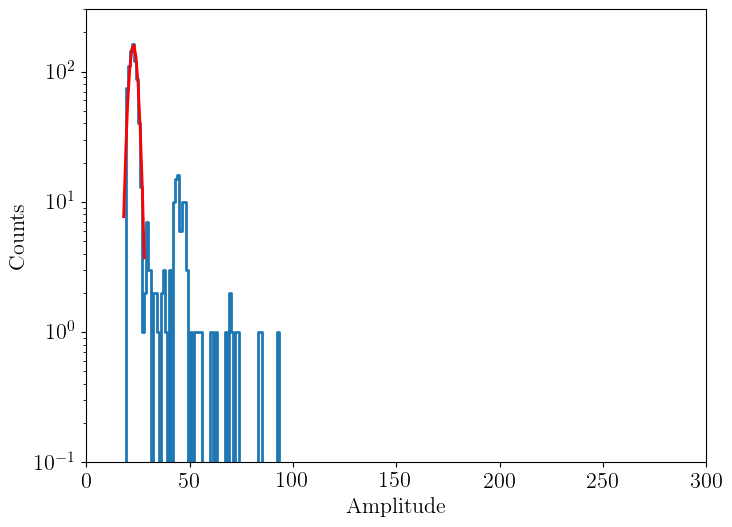

[[ 6.21837055e+01  7.08827421e-04 -4.97998978e-01]
 [ 7.08827421e-04  1.18406840e-02 -1.93165743e-05]
 [-4.97998978e-01 -1.93165743e-05  1.19189528e-02]]
[22.731685449732627]
[0.10881490704299134]


In [14]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height_positive=[]

for vals in peak_height:
    if (vals>0):
        peak_height_positive.append(vals)
    

h,hx = np.histogram(peak_height_positive, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height_positive)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,2):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+(5/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print('peak_height',peak_height_positive)
# print('median_pe',pe)
# print ('pe_fit= ',pe_fit)
# print(popt)
# gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
# gain = np.insert(gain,0,pe_fit[0,1])
print(pcov)
gain_list=[]
bias_list=[]
gain_err_list=[]
gain=popt[1]
gain_list.append(gain)
gain_err=np.sqrt(np.diag(pcov))
gain_err_list.append(gain_err[1])
print(gain_list)
print(gain_err_list)


0.15784314243734943
[0.2221912747754391]
[0.01330612313515402]


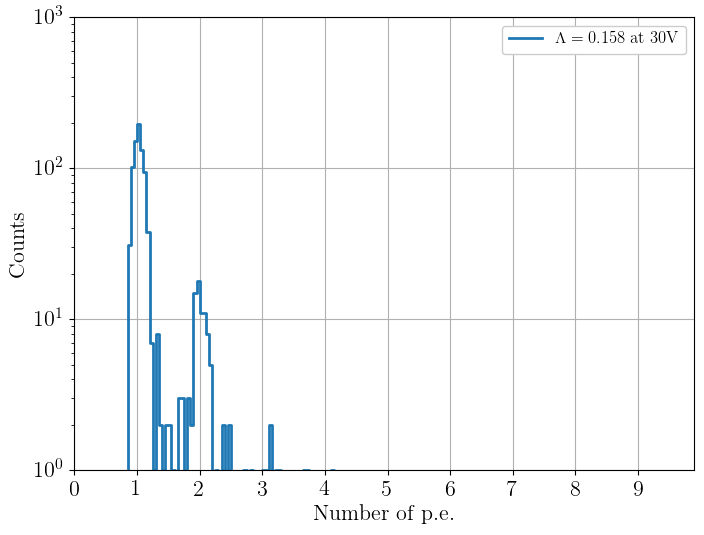

In [15]:
ca_list=[]
Yale_ca_err=[]
Yale_ca_RMS=[]
peak_height_calib = np.array(peak_height_positive)/np.mean(gain)
ca = (np.mean(peak_height_calib) - 1)
# print(peak_height_calib)

ca_list.append(ca)
Yale_ca_RMS.append(np.sqrt(np.mean(np.square(peak_height_calib)))-1)
Yale_ca_err.append(np.std(peak_height_calib)/np.sqrt(len(peak_height_calib)))
print(ca)
print(Yale_ca_RMS)
print(Yale_ca_err)
h,hx = np.histogram(peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V'.format(ca))
plt.legend(loc='upper right')
# plt.savefig('deconvolution_hist_pe_calib_11-19-21.pdf')
plt.show()


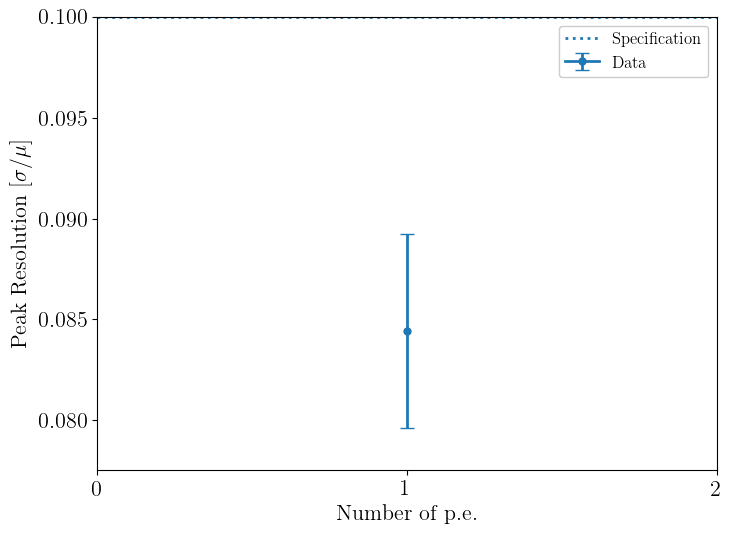

In [16]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [17]:
data = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_31V*.h5')
data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data.Files)):

    print(i,File)
    print('Getting data...')
    data.ImportDataFromHDF5(File, data.Ch)

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_0.h5
Getting data...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_9.h5
Gettin

In [18]:
for ii,ch in enumerate(data.Ch):
    ch.Amp=np.array(ch.Amp)

In [19]:
fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
nyq=0.5*fs

In [20]:
order=3
lowfreq=100
highfreq=100000
# type='band'

b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

In [21]:
filtered_amp=[]
# fig=plt.figure(figsize=(8,6))
for ii,amp in enumerate(data.Ch[0].Amp):
#     plt.plot(data.Ch[0].Time,amp,lw=0.01,color='k',label='Original')
    filtamp = filtfilt(b,a,amp)
    filtered_amp.append(filtamp)
#     plt.plot(data.Ch[0].Time,filtamp,color='blue',lw=0.1,label='Butter Filtered')
#     plt.xlabel('Time($\mu$s)')
#     plt.ylabel('Amplitude(mV)')
#     plt.legend(loc=1)
# plt.ylim(-200,1000)    
# plt.show()
print(len(filtered_amp))

1983


In [22]:
desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
desire_y = gauss_conv(desire_x)
desire_f = np.fft.fft(desire_y)

resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
resp_f = np.fft.fft(resp_y)

filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

# plt.figure(figsize=(4,2))
# plt.plot(resp_x, resp_y,label='Response')
# plt.plot(desire_x, desire_y,label='Desired')
# plt.show()

In [23]:
# print(np.convolve(filtered_amp,filter_y,'same'))
convol_list=[]
for ii,vals in enumerate(filtered_amp):
    convol=np.convolve(vals,filter_y,'same')
    convol_list.append(convol)
#     plt.plot(data.Ch[0].Time,convol,color='red',lw=1,label='Deconvolved')
#     plt.plot(data.Ch[0].Time,vals,color='k',lw=1,label='Response')
#     plt.xlabel('Time($\mu$s)')
#     plt.xlim(0,200)
#     plt.ylabel('Amplitude(mV)')
# plt.show()
# print(convol_list)

In [24]:
peak_height = []
peak_pos = []
peak_num = []
peak_wvf_num = []
wvf_num = 0

for ii,vals in enumerate(convol_list):
    peaks,pdict=find_peaks(vals,height=28,distance=1)
    if len(peaks)>0:
        peak_height.extend(pdict['peak_heights'])
        peak_pos.extend(data.Ch[0].Time[peaks])
        peak_num.extend([len(peaks)])
        peak_wvf_num.extend([wvf_num]*len(peaks))
    else:
        peak_height.extend([-99999.99])
        peak_pos.extend([-99999.99])
        peak_num.extend([0])
        peak_wvf_num.extend([wvf_num])
    wvf_num += 1

Single pe = 33.51760564698567


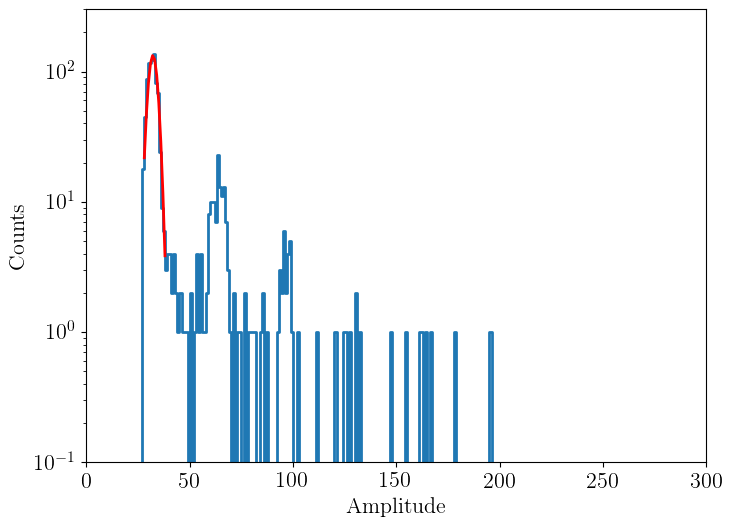

[22.731685449732627, 32.16813045682095]


In [25]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height_positive=[]

for vals in peak_height:
    if (vals>0):
        peak_height_positive.append(vals)
    

h,hx = np.histogram(peak_height_positive, bins=np.arange(0,300,1))


pe = np.median(peak_height_positive)
print('Single pe =',pe)

pe_fit = []

plt.figure()
for i in range(1,2):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+(5/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print('peak_height',peak_height_positive)
# print('median_pe',pe)
# print ('pe_fit= ',pe_fit)
# gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
# gain = np.insert(gain,0,pe_fit[0,1])
gain=popt[1]

gain_list.append(gain)
gain_err=np.sqrt(np.diag(pcov))
gain_err_list.append(gain_err[1])
print(gain_list)

[0.15784314243734943, 0.30523195552324434]
[0.2221912747754391, 0.4967487856422854]
[0.01330612313515402, 0.024177684430146108]


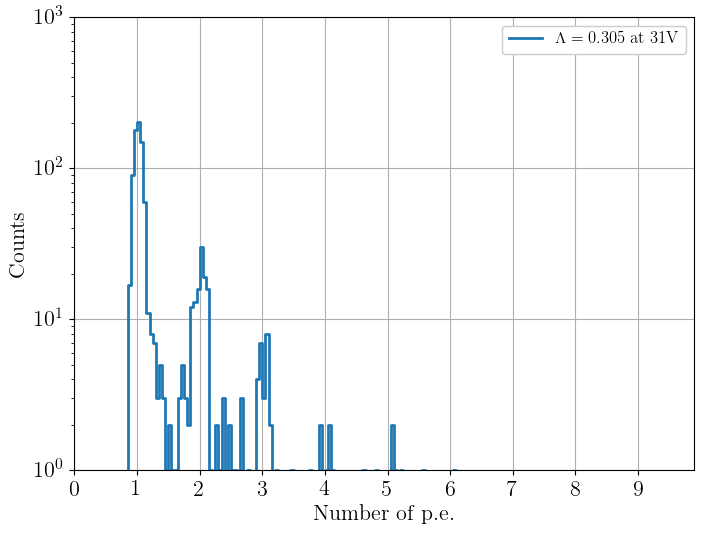

In [26]:
peak_height_calib = np.array(peak_height_positive)/np.mean(gain)
ca = (np.mean(peak_height_calib) - 1)
# print(peak_height_calib)

ca_list.append(ca)
Yale_ca_err.append(np.std(peak_height_calib)/np.sqrt(len(peak_height_calib)))
Yale_ca_RMS.append(np.sqrt(np.mean(np.square(peak_height_calib)))-1)
print(ca_list)
print(Yale_ca_RMS)
print(Yale_ca_err)
h,hx = np.histogram(peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V'.format(ca))
plt.legend(loc='upper right')
# plt.savefig('deconvolution_hist_pe_calib_11-19-21.pdf')
plt.show()


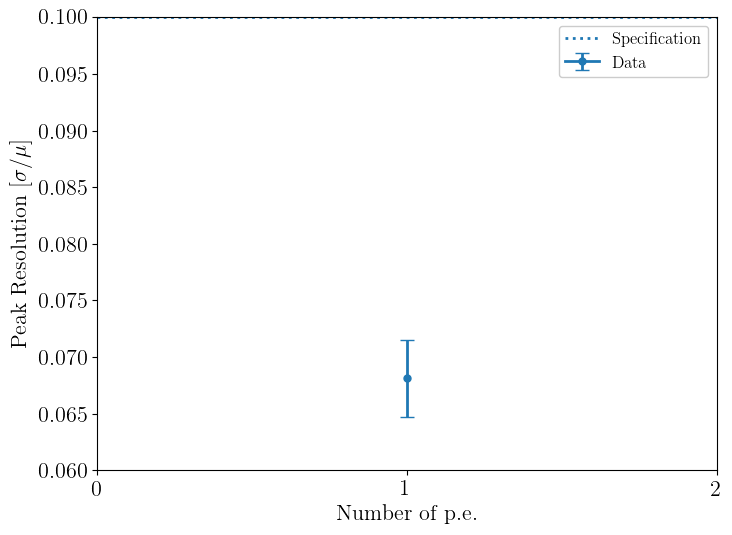

In [27]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
# plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

In [28]:
data = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_32V*.h5')
data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data.Files)):

    print(i,File)
    print('Getting data...')
    data.ImportDataFromHDF5(File, data.Ch)

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_0.h5
Getting data...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_9.h5
Gettin

In [29]:
for ii,ch in enumerate(data.Ch):
    ch.Amp=np.array(ch.Amp)

In [30]:
fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
nyq=0.5*fs

In [31]:
order=3
lowfreq=100
highfreq=100000
# type='band'

b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

In [32]:
filtered_amp=[]
# fig=plt.figure(figsize=(8,6))
for ii,amp in enumerate(data.Ch[0].Amp):
#     plt.plot(data.Ch[0].Time,amp,lw=0.01,color='k',label='Original')
    filtamp = filtfilt(b,a,amp)
    filtered_amp.append(filtamp)
#     plt.plot(data.Ch[0].Time,filtamp,color='blue',lw=0.1,label='Butter Filtered')
#     plt.xlabel('Time($\mu$s)')
#     plt.ylabel('Amplitude(mV)')
#     plt.legend(loc=1)
# plt.ylim(-200,1000)    
# plt.show()
print(len(filtered_amp))

2016


In [33]:
desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
desire_y = gauss_conv(desire_x)
desire_f = np.fft.fft(desire_y)

resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
resp_f = np.fft.fft(resp_y)

filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

# plt.figure(figsize=(4,2))
# plt.plot(resp_x, resp_y,label='Response')
# plt.plot(desire_x, desire_y,label='Desired')
# plt.show()

In [34]:
# print(np.convolve(filtered_amp,filter_y,'same'))
convol_list=[]
for ii,vals in enumerate(filtered_amp):
    convol=np.convolve(vals,filter_y,'same')
    convol_list.append(convol)
#     plt.plot(data.Ch[0].Time,convol,color='red',lw=1,label='Deconvolved')
#     plt.plot(data.Ch[0].Time,vals,color='k',lw=1,label='Response')
#     plt.xlabel('Time($\mu$s)')
#     plt.xlim(0,200)
#     plt.ylabel('Amplitude(mV)')
# plt.show()
# print(convol_list)

In [35]:
peak_height = []
peak_pos = []
peak_num = []
peak_wvf_num = []
wvf_num = 0

for ii,vals in enumerate(convol_list):
    peaks,pdict=find_peaks(vals,height=35,distance=1)
    if len(peaks)>0:
        peak_height.extend(pdict['peak_heights'])
        peak_pos.extend(data.Ch[0].Time[peaks])
        peak_num.extend([len(peaks)])
        peak_wvf_num.extend([wvf_num]*len(peaks))
    else:
        peak_height.extend([-99999.99])
        peak_pos.extend([-99999.99])
        peak_num.extend([0])
        peak_wvf_num.extend([wvf_num])
    wvf_num += 1

Single pe = 43.992216752269485


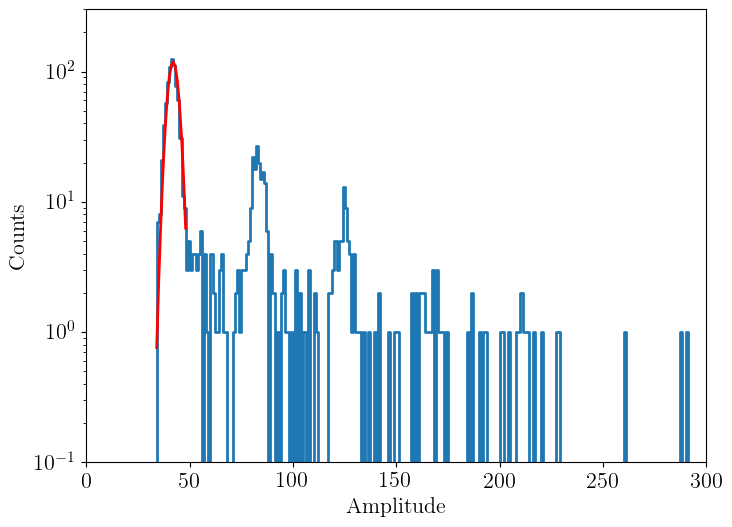

[22.731685449732627, 32.16813045682095, 41.940671090064264]
[0.10881490704299134, 0.1054615573422363, 0.065132748511986]


In [36]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height_positive=[]

for vals in peak_height:
    if (vals>0):
        peak_height_positive.append(vals)
    

h,hx = np.histogram(peak_height_positive, bins=np.arange(0,300,1))

pe = np.median(peak_height_positive)
print('Single pe =',pe)

pe_fit = []

plt.figure()
for i in range(1,2):
    cut = np.where((hx[:-1]>pe*i-10) & (hx[:-1]<pe*i+(5/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print('peak_height',peak_height_positive)
# print('median_pe',pe)
# print ('pe_fit= ',pe_fit)
# gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
# gain = np.insert(gain,0,pe_fit[0,1])
gain=popt[1]
gain_list.append(gain)
gain_err=np.sqrt(np.diag(pcov))
gain_err_list.append(gain_err[1])
print(gain_list)
print(gain_err_list)

[0.15784314243734943, 0.30523195552324434, 0.5140420377845927]
[0.2221912747754391, 0.4967487856422854, 0.8323606602743516]
[0.01330612313515402, 0.024177684430146108, 0.030812270068232513]


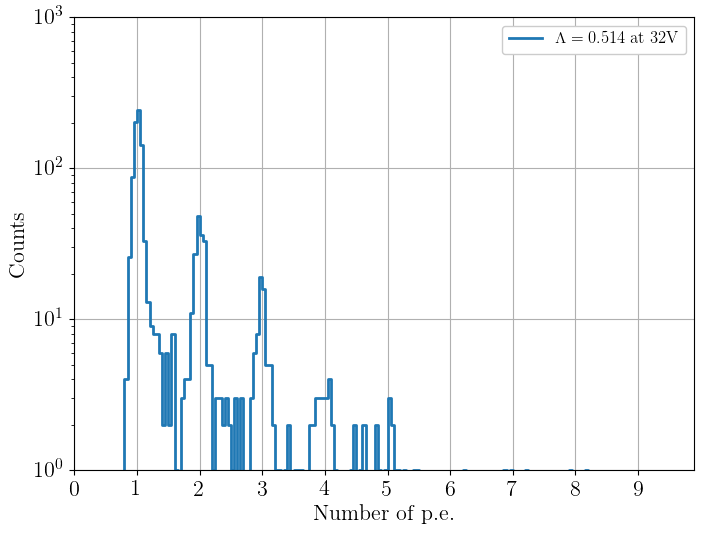

In [37]:
peak_height_calib = np.array(peak_height_positive)/np.mean(gain)
ca = (np.mean(peak_height_calib) - 1)

ca_list.append(ca)
Yale_ca_err.append(np.std(peak_height_calib)/np.sqrt(len(peak_height_calib)))
Yale_ca_RMS.append(np.sqrt(np.mean(np.square(peak_height_calib)))-1)
print(ca_list)
print(Yale_ca_RMS)
print(Yale_ca_err)
h,hx = np.histogram(peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.3f}$ at 32V'.format(ca))
plt.legend(loc='upper right')
# plt.savefig('deconvolution_hist_pe_calib_11-19-21.pdf')
plt.show()


In [38]:
data = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_33V*.h5')
data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data.Files)):

    print(i,File)
    print('Getting data...')
    data.ImportDataFromHDF5(File, data.Ch)

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_0.h5
Getting data...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_9.h5
Gettin

In [39]:
for ii,ch in enumerate(data.Ch):
    ch.Amp=np.array(ch.Amp)

In [40]:
fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
nyq=0.5*fs

In [41]:
order=3
lowfreq=100
highfreq=100000
# type='band'

b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

In [42]:
filtered_amp=[]
# fig=plt.figure(figsize=(8,6))
for ii,amp in enumerate(data.Ch[0].Amp):
#     plt.plot(data.Ch[0].Time,amp,lw=0.01,color='k',label='Original')
    filtamp = filtfilt(b,a,amp)
    filtered_amp.append(filtamp)
#     plt.plot(data.Ch[0].Time,filtamp,color='blue',lw=0.1,label='Butter Filtered')
#     plt.xlabel('Time($\mu$s)')
#     plt.ylabel('Amplitude(mV)')
#     plt.legend(loc=1)
# plt.ylim(-200,1000)    
# plt.show()
print(len(filtered_amp))

1460


In [43]:
desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
desire_y = gauss_conv(desire_x)
desire_f = np.fft.fft(desire_y)

resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
resp_f = np.fft.fft(resp_y)

filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

# plt.figure(figsize=(4,2))
# plt.plot(resp_x, resp_y,label='Response')
# plt.plot(desire_x, desire_y,label='Desired')
# plt.show()

In [44]:
# print(np.convolve(filtered_amp,filter_y,'same'))
convol_list=[]
for ii,vals in enumerate(filtered_amp):
    convol=np.convolve(vals,filter_y,'same')
    convol_list.append(convol)
#     plt.plot(data.Ch[0].Time,convol,color='red',lw=1,label='Deconvolved')
#     plt.plot(data.Ch[0].Time,vals,color='k',lw=1,label='Response')
#     plt.xlabel('Time($\mu$s)')
#     plt.xlim(0,200)
#     plt.ylabel('Amplitude(mV)')
# plt.show()
# print(convol_list)

In [45]:
peak_height = []
peak_pos = []
peak_num = []
peak_wvf_num = []
wvf_num = 0

for ii,vals in enumerate(convol_list):
    peaks,pdict=find_peaks(vals,height=42,distance=1)
    if len(peaks)>0:
        peak_height.extend(pdict['peak_heights'])
        peak_pos.extend(data.Ch[0].Time[peaks])
        peak_num.extend([len(peaks)])
        peak_wvf_num.extend([wvf_num]*len(peaks))
    else:
        peak_height.extend([-99999.99])
        peak_pos.extend([-99999.99])
        peak_num.extend([0])
        peak_wvf_num.extend([wvf_num])
    wvf_num += 1

Single pe = 55.5132079029257


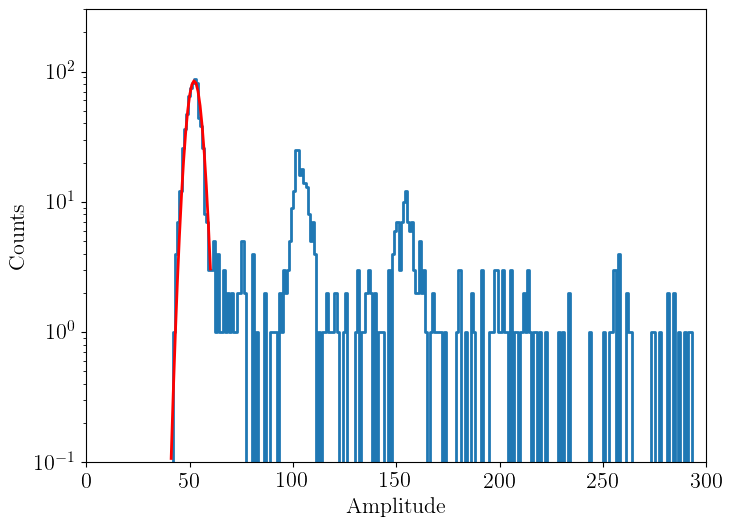

[22.731685449732627, 32.16813045682095, 41.940671090064264, 52.13702175133124]
[0.10881490704299134, 0.1054615573422363, 0.065132748511986, 0.10123623422913887]


In [46]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height_positive=[]

for vals in peak_height:
    if (vals>0):
        peak_height_positive.append(vals)
    

h,hx = np.histogram(peak_height_positive, bins=np.arange(0,300,1))
# print(h)
# print(hx)

pe = np.median(peak_height_positive)
print('Single pe =',pe)
# print(np.max(peak_height))
pe_fit = []

plt.figure()
for i in range(1,2):
    cut = np.where((hx[:-1]>pe*i-15) & (hx[:-1]<pe*i+(5/i)))
#     print (pe*i-8,pe*i+(6/i))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print('peak_height',peak_height_positive)
# print('median_pe',pe)
# print ('pe_fit= ',pe_fit)
# gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
# gain = np.insert(gain,0,pe_fit[0,1])
# gain_list.append(np.mean(gain))

gain=popt[1]
gain_list.append(gain)
gain_err=np.sqrt(np.diag(pcov))
gain_err_list.append(gain_err[1])
print(gain_list)
print(gain_err_list)

[0.15784314243734943, 0.30523195552324434, 0.5140420377845927, 0.7957588930512121]
[0.2221912747754391, 0.4967487856422854, 0.8323606602743516, 1.3110109830387464]
[0.01330612313515402, 0.024177684430146108, 0.030812270068232513, 0.04389943136825881]


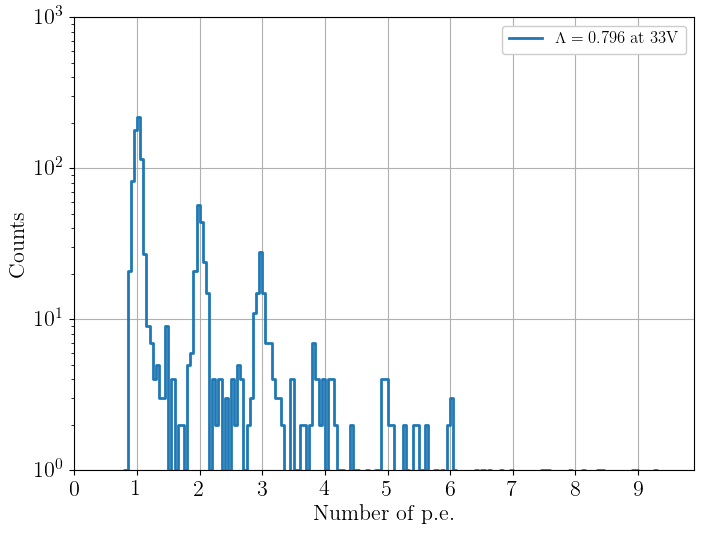

In [47]:
peak_height_calib = np.array(peak_height_positive)/np.mean(gain)
ca = (np.mean(peak_height_calib) - 1)
ca_list.append(ca)
Yale_ca_err.append(np.std(peak_height_calib)/np.sqrt(len(peak_height_calib)))
Yale_ca_RMS.append(np.sqrt(np.mean(np.square(peak_height_calib)))-1)
print(ca_list)
print(Yale_ca_RMS)
print(Yale_ca_err)
h,hx = np.histogram(peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.3f}$ at 33V'.format(ca))
plt.legend(loc='upper right')
# plt.savefig('deconvolution_hist_pe_calib_11-19-21.pdf')
plt.show()


In [48]:
data = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_34V*.h5')
data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data.Files)):

    print(i,File)
    print('Getting data...')
    data.ImportDataFromHDF5(File, data.Ch)

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_0.h5
Getting data...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_8.h5
Getting data...
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_9.h5
Gettin

In [49]:
for ii,ch in enumerate(data.Ch):
    ch.Amp=np.array(ch.Amp)

In [50]:
fs=1/(np.mean(np.diff(data.Ch[0].Time))/data.Ch[0].TScale)
nyq=0.5*fs

In [51]:
order=3
lowfreq=100
highfreq=100000
# type='band'

b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)

In [52]:
filtered_amp=[]
# fig=plt.figure(figsize=(8,6))
for ii,amp in enumerate(data.Ch[0].Amp):
#     plt.plot(data.Ch[0].Time,amp,lw=0.01,color='k',label='Original')
    filtamp = filtfilt(b,a,amp)
    filtered_amp.append(filtamp)
#     plt.plot(data.Ch[0].Time,filtamp,color='blue',lw=0.1,label='Butter Filtered')
#     plt.xlabel('Time($\mu$s)')
#     plt.ylabel('Amplitude(mV)')
#     plt.legend(loc=1)
# plt.ylim(-200,1000)    
# plt.show()
print(len(filtered_amp))

1001


In [53]:
desire_x = np.arange(-500,500, data.Ch[0].Time[1]-data.Ch[0].Time[0])
desire_y = gauss_conv(desire_x)
desire_f = np.fft.fft(desire_y)

resp_x = np.arange(0,1000, data.Ch[0].Time[1]-data.Ch[0].Time[0])
resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
resp_f = np.fft.fft(resp_y)

filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

# plt.figure(figsize=(4,2))
# plt.plot(resp_x, resp_y,label='Response')
# plt.plot(desire_x, desire_y,label='Desired')
# plt.show()

In [54]:
# print(np.convolve(filtered_amp,filter_y,'same'))
convol_list=[]
for ii,vals in enumerate(filtered_amp):
    convol=np.convolve(vals,filter_y,'same')
    convol_list.append(convol)
#     plt.plot(data.Ch[0].Time,convol,color='red',lw=1,label='Deconvolved')
#     plt.plot(data.Ch[0].Time,vals,color='k',lw=1,label='Response')
#     plt.xlabel('Time($\mu$s)')
#     plt.xlim(0,200)
#     plt.ylabel('Amplitude(mV)')
# plt.show()
# print(convol_list)

In [55]:
peak_height = []
peak_pos = []
peak_num = []
peak_wvf_num = []
wvf_num = 0

for ii,vals in enumerate(convol_list):
    peaks,pdict=find_peaks(vals,height=55,distance=1)
    if len(peaks)>0:
        peak_height.extend(pdict['peak_heights'])
        peak_pos.extend(data.Ch[0].Time[peaks])
        peak_num.extend([len(peaks)])
        peak_wvf_num.extend([wvf_num]*len(peaks))
    else:
        peak_height.extend([-99999.99])
        peak_pos.extend([-99999.99])
        peak_num.extend([0])
        peak_wvf_num.extend([wvf_num])
    wvf_num += 1

Single pe = 89.49871107193965


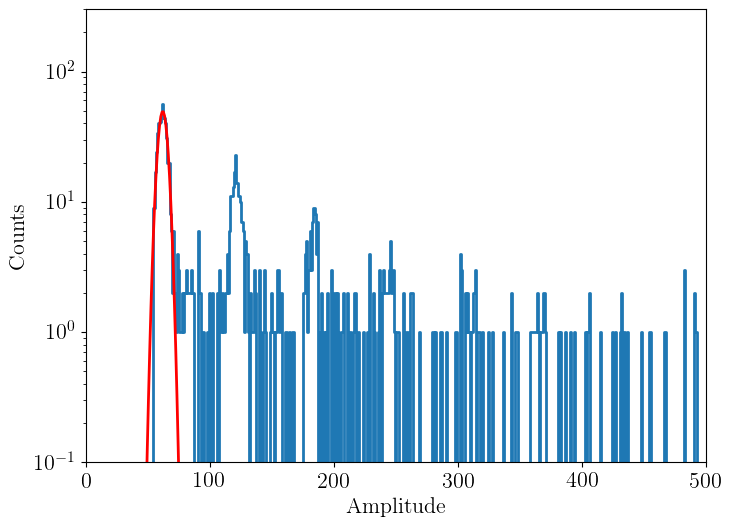

[22.731685449732627, 32.16813045682095, 41.940671090064264, 52.13702175133124, 61.54879231719795]
[0.10881490704299134, 0.1054615573422363, 0.065132748511986, 0.10123623422913887, 0.19976050836780415]


In [56]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

peak_height_positive=[]

for vals in peak_height:
    if (vals>0):
        peak_height_positive.append(vals)
    

h,hx = np.histogram(peak_height_positive, bins=np.arange(0,500,1))

pe = np.median(peak_height_positive)
# pe = float(hx[np.where(h==np.max(h))])
print('Single pe =',pe)
# print(np.max(peak_height))
# print(hx[np.where(h==np.max(h))])
pe_fit = []

plt.figure()
for i in range(1,2):
    cut = np.where((hx[:-1]>pe*i-(50)) & (hx[:-1]<pe*i+(50)))
#     print (pe*i-(10),pe*i+(10))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

pe_fit = np.array(pe_fit)


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.1,300)
plt.step(hx[:-1], h, lw=2)
plt.show()
# print('peak_height',peak_height_positive)
# print('median_pe',pe)
# print ('pe_fit= ',pe_fit)
# gain = np.diff(pe_fit[:,1])
# print ('gain_diff=',gain)
# gain = np.insert(gain,0,pe_fit[0,1])
# gain_list.append(np.mean(gain))
gain=popt[1]
gain_list.append(gain)
gain_err=np.sqrt(np.diag(pcov))
gain_err_list.append(gain_err[1])
print(gain_list)
print(gain_err_list)

1.4653127288335992
[0.01330612313515402, 0.024177684430146108, 0.030812270068232513, 0.04389943136825881, 0.08374673434396473]
[0.2221912747754391, 0.4967487856422854, 0.8323606602743516, 1.3110109830387464, 2.5693986312211807]


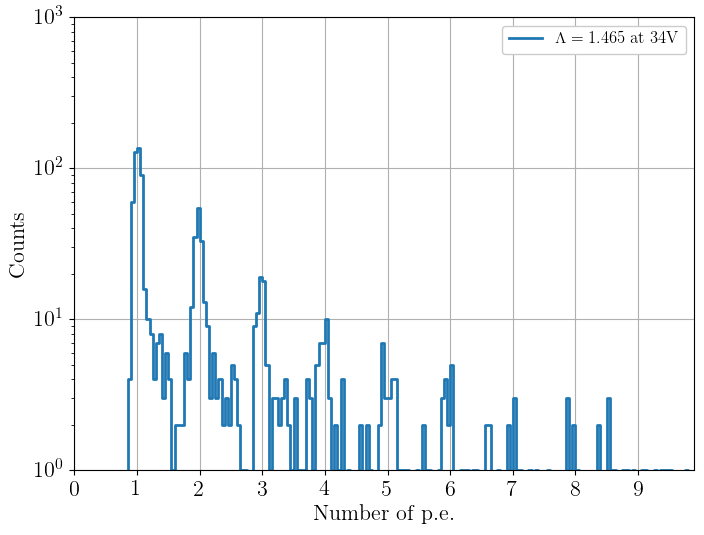

In [57]:
peak_height_calib = np.array(peak_height_positive)/np.mean(gain)
ca = (np.mean(peak_height_calib) - 1)
# print(peak_height_calib)

ca_list.append(ca)
Yale_ca_err.append(np.std(peak_height_calib)/np.sqrt(len(peak_height_calib)))
Yale_ca_RMS.append(np.sqrt(np.mean(np.square(peak_height_calib)))-1)
print(ca)
print(Yale_ca_err)
print(Yale_ca_RMS)
h,hx = np.histogram(peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.3f}$ at 34V'.format(ca))
plt.legend(loc='upper right')
# plt.savefig('deconvolution_hist_pe_calib_11-19-21.pdf')
plt.show()


[2.30356242 3.30356242 4.30356242 5.30356242 6.30356242]
0.017631555719877758


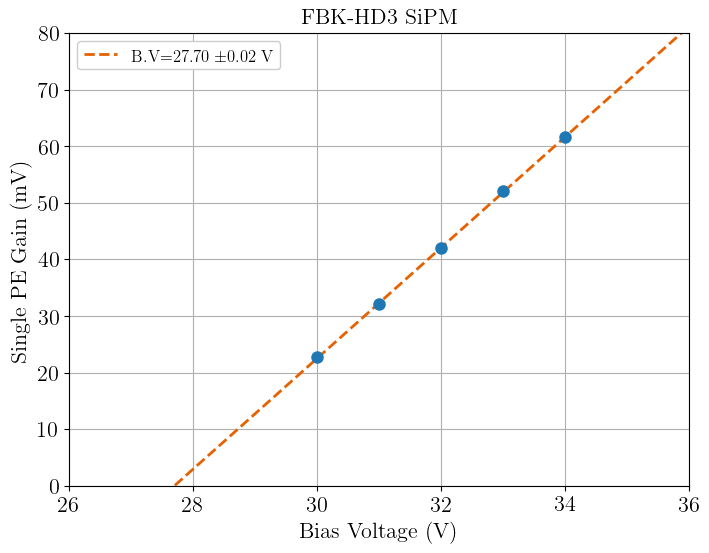

In [58]:
def func_line(x,a,b):
    return (x-a)*b
fig=plt.figure(figsize=(8,6))
x_data=np.linspace(26,36,100)
bv_list=[30,31,32,33,34]
plt.errorbar(bv_list,gain_list,fmt='o',ms=8)
popt,pcov=curve_fit(func_line,bv_list,gain_list,p0=[27.5,0.2],sigma=gain_err_list,maxfev=100000)
plt.plot(x_data,func_line(x_data,*popt),'--',label='B.V={:.2f} $\pm${:.2f} V'.format(popt[0],np.sqrt(np.diag(pcov))[0]))


plt.xlabel('Bias Voltage (V)')
plt.ylabel('Single PE Gain (mV)')
plt.legend(loc=2)
plt.xlim(26,36)
plt.ylim(0,80)
plt.title('FBK-HD3 SiPM')
plt.grid()
# plt.savefig('gainvsbias.pdf')

breakdown_V=popt[0]

ov_list=bv_list-breakdown_V
print(ov_list)
Yale_bv_err=np.sqrt(np.diag(pcov))[0]
print(Yale_bv_err)
plt.savefig('gain_bv.pdf')
plt.show()

In [59]:
df_triumf1=pd.read_csv('nCP_VUVHD3_110_RMS.txt',sep=",",header=None)
# print(df_triumf1)
df_triumf1.columns=['OV','OV_err','TNA','CA','RMS']

df_triumf2=pd.read_csv('nCP_VUVHD3_110_2_RMS.txt',sep=",",header=None)
df_triumf2.columns=['OV','OV_err','TNA','CA','RMS']

df_triumf3=pd.read_csv('nCP_VUVHD3_110_2_RMS.txt',sep=",",header=None)
df_triumf3.columns=['OV','OV_err','TNA','CA','RMS']

df_HEP=pd.read_csv('nCP_VUVHD3_iHEP_50C.txt',sep=",",header=None)

df_HEP.columns=['OV','OV_err','CA','CA_err','RMS']

BNL_OV=[0.87,1.87,2.87,3.87,4.87,5.87,6.87]
BNL_ca=[0.085,0.15,0.301,0.543,0.8327,1.327,2.17]
BNL_ca_RMS=[]

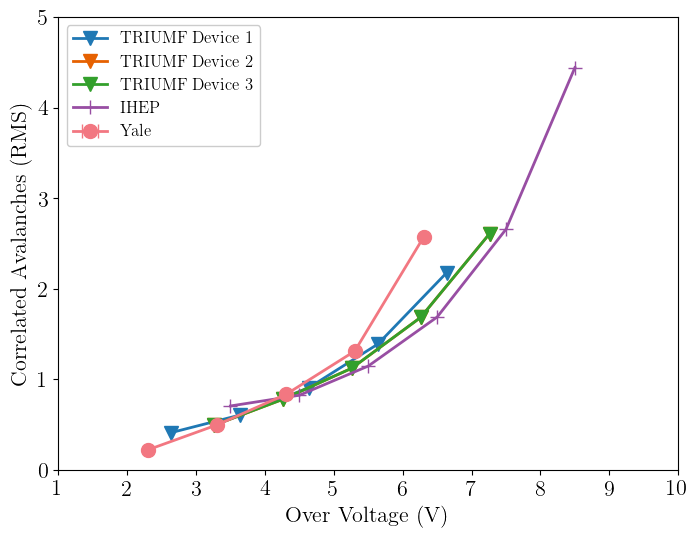

In [60]:
plt.figure(figsize=(8,6))

plt.errorbar(df_triumf1['OV'],df_triumf1['RMS'],fmt='-v',label='TRIUMF Device 1')
plt.errorbar(df_triumf2['OV'],df_triumf2['RMS'],fmt='-v',label='TRIUMF Device 2')
plt.errorbar(df_triumf3['OV'],df_triumf3['RMS'],fmt='-v',label='TRIUMF Device 3')
plt.errorbar(df_HEP['OV'],df_HEP['RMS'],label='IHEP',fmt='-+')
plt.errorbar(ov_list,Yale_ca_RMS,xerr=Yale_bv_err,fmt='-o',label='Yale')
plt.xlabel('Over Voltage (V)')
plt.ylabel('Correlated Avalanches (RMS)')
plt.xlim(1,10)
plt.ylim(0,5)
plt.legend(loc=2)

plt.savefig('ca_RMS_ov.pdf')
plt.show()

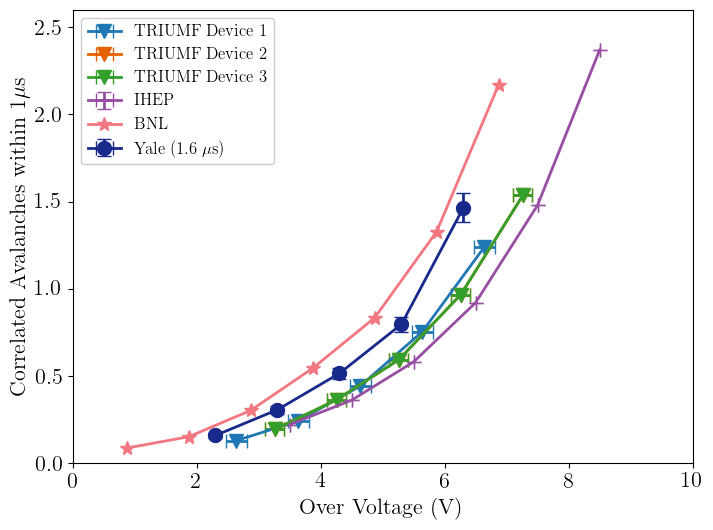

In [66]:
plt.figure(figsize=(8,6))
plt.errorbar(df_triumf1['OV'],df_triumf1['CA'],xerr=df_triumf1['OV_err'],fmt='-v',label='TRIUMF Device 1')
plt.errorbar(df_triumf2['OV'],df_triumf2['CA'],xerr=df_triumf2['OV_err'],fmt='-v',label='TRIUMF Device 2')
plt.errorbar(df_triumf3['OV'],df_triumf3['CA'],xerr=df_triumf3['OV_err'],fmt='-v',label='TRIUMF Device 3')
plt.errorbar(df_HEP['OV'],df_HEP['CA'],xerr=df_HEP['OV_err'],yerr=df_HEP['CA_err'],label='IHEP')
plt.errorbar(BNL_OV,BNL_ca,fmt='-*',label='BNL')
plt.errorbar(ov_list,ca_list,xerr=Yale_bv_err,yerr=Yale_ca_err,fmt='-o',label='Yale (1.6 $\mu$s)')
plt.xlabel('Over Voltage (V)')
plt.ylabel('Correlated Avalanches within 1$\mu$s')
plt.xlim(0,10)
plt.ylim(0,2.6)
plt.legend(loc=2)
plt.savefig('ca_ov.pdf')
plt.show()